# Create a polynomial chaos for the Ishigami function

In this example, we create a polynomial chaos for the Ishigami function. We create a sparse polynomial with maximum total degree equal to 8. 

In [1]:
import openturns as ot
from math import pi
import openturns.viewer as otv

Create the Ishigami test function.

In [2]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

Create the probabilistic model

In [3]:
distributionList = [ot.Uniform(-pi, pi)] * 3
distribution = ot.ComposedDistribution(distributionList)

Create a training sample

In [4]:
N = 100 
inputTrain = distribution.getSample(N)
outputTrain = g(inputTrain)

Create the chaos.

We could use only the input and output training samples: in this case, the distribution of the input sample is computed by selecting the best distribution that fits the data. 

In [5]:
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain)

Since the input distribution is known in our particular case, we instead create the multivariate basis from the distribution.

In [6]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(distributionList)
selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
projectionStrategy = ot.LeastSquaresStrategy(inputTrain, outputTrain, selectionAlgorithm)
totalDegree = 8
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain, distribution, adaptiveStrategy, projectionStrategy)

In [7]:
chaosalgo.run()
result = chaosalgo.getResult()
metamodel = result.getMetaModel()

In order to validate the metamodel, we generate a test sample.

In [8]:
n_valid = 1000
inputTest = distribution.getSample(n_valid)
outputTest = g(inputTest)
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()
Q2

0.9992361845215688

The Q2 is very close to 1: the metamodel is excellent.

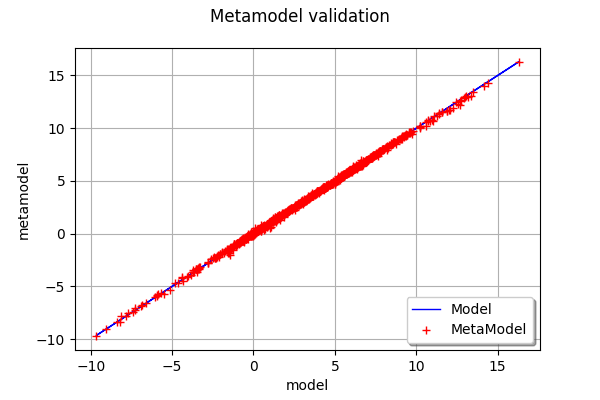

In [9]:
val.drawValidation()

Print Sobol' indices

In [10]:
chaosSI = ot.FunctionalChaosSobolIndices(result) 
print(chaosSI.summary())

 input dimension: 3
 output dimension: 1
 basis size: 26
 mean: [3.50804]
 std-dev: [3.70043]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      7 | [0,4,0]                       | 0.279938
      1 | [1,0,0]                       | 0.190322
      6 | [1,0,2]                       | 0.136823
     15 | [0,6,0]                       | 0.130033
      5 | [3,0,0]                       | 0.12058
     11 | [3,0,2]                       | 0.0837457
      3 | [0,2,0]                       | 0.0250262
     12 | [1,0,4]                       | 0.0111867
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.313447               | 0.55526               
       

We notice the a coefficient with marginal degree equal to 6 has a significant impact on the output variance. Hence, we cannot get a satisfactory polynomial chaos with total degree less that 6. 

Draw Sobol' indices

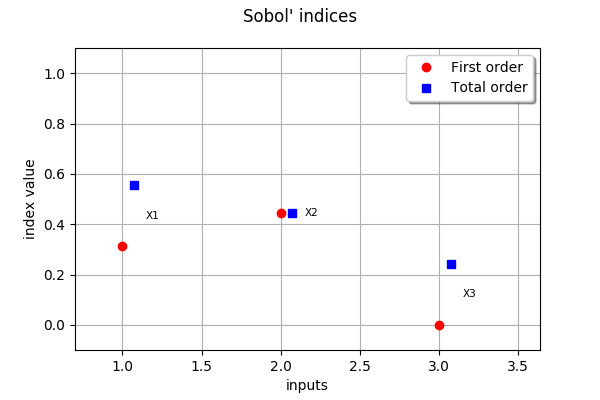

In [11]:
dim_input = distribution.getDimension()
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

The variable which has the largest impact on the output is, taking interactions into account, X1. 

We see that X1 has interactions with other variables, since the first order indice is less than the total order indice.

At first order, X3 has no interactions with other variables since its first order indice is close to zero.